┌────────────┬─────────┬─────────────────────┬──────────────────────┬──────────────────────────────────────┬───────────┐
│  database  │ schema  │        name         │     column_names     │             column_types             │ temporary │
│  varchar   │ varchar │       varchar       │      varchar[]       │              varchar[]               │  boolean  │
├────────────┼─────────┼─────────────────────┼──────────────────────┼──────────────────────────────────────┼───────────┤
│ employment │ main    │ business_employment │ [Series_reference,…  │ [VARCHAR, DOUBLE, DOUBLE, VARCHAR,…  │ false     │
│ employment │ main    │ business_financial  │ [Series_reference,…  │ [VARCHAR, DOUBLE, DOUBLE, VARCHAR,…  │ false     │
└────────────┴─────────┴─────────────────────┴──────────────────────┴──────────────────────────────────────┴───────────┘

    Period  Gender  Total_Earnings
0  2012.03  Female     8528.554026
1  2012.03    Male    12536.791400
2  2012.06  Female     8873.395656
3  2012.06  

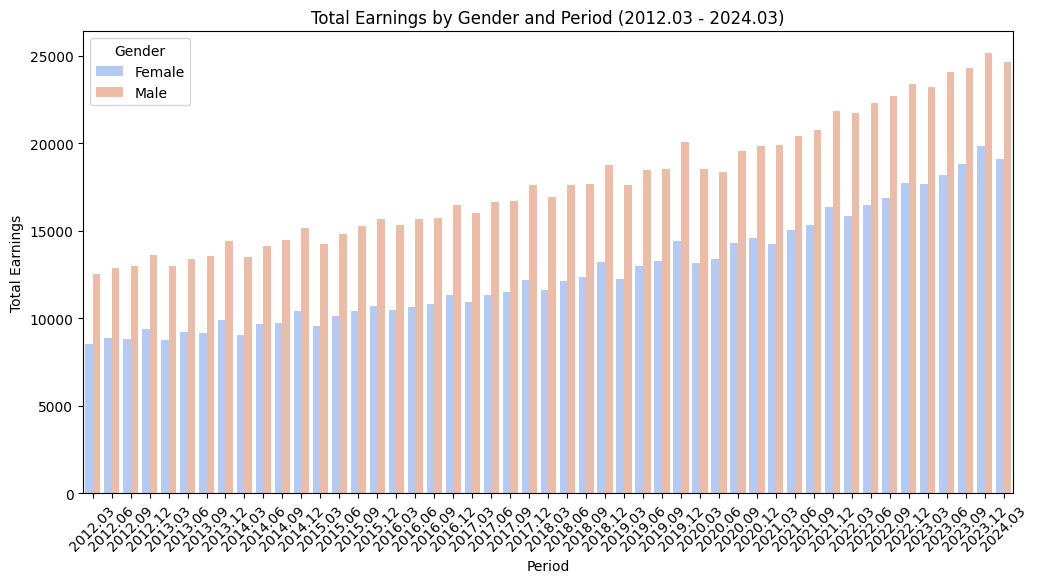

    Period  Gender  Filled_jobs
0  2012.03  Female     855472.0
1  2012.03    Male     873443.0
2  2012.06  Female     878971.0
3  2012.06    Male     878354.0
4  2012.09  Female     870937.0


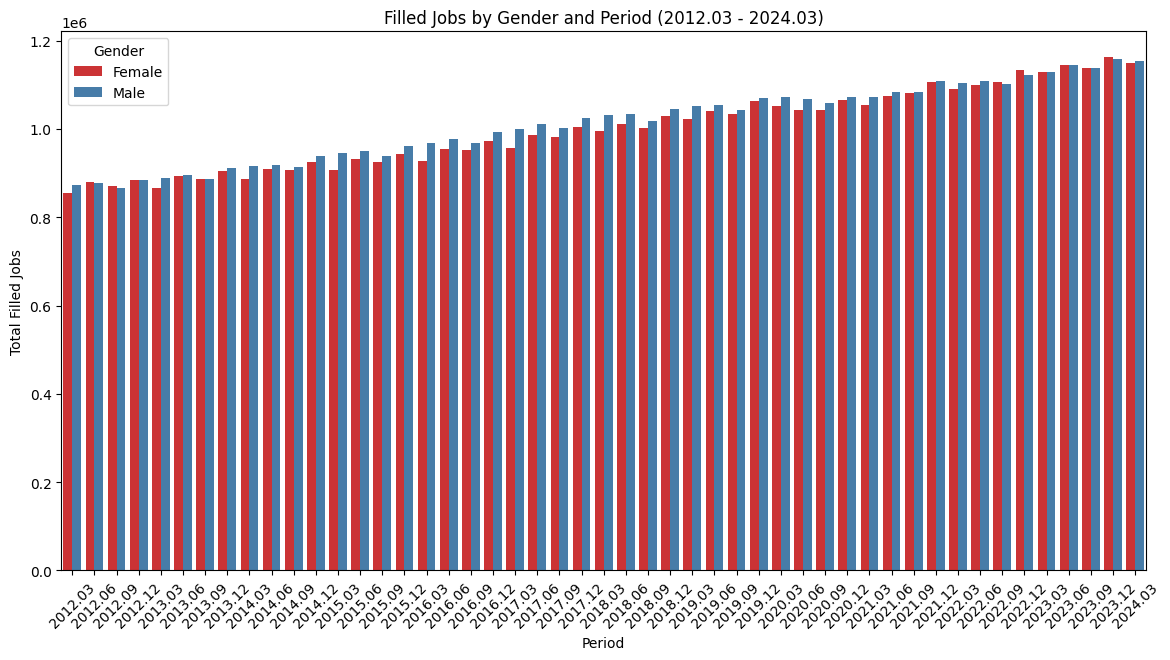

In [23]:
#!pip install matplotlib seaborn plotly

import requests
import zipfile
import duckdb
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# URL of the ZIP file
url1 = "https://www.stats.govt.nz/assets/Uploads/Business-employment-data/Business-employment-data-March-2024-quarter/Download-data/business-employment-data-march-2024-quarter.zip"
url2 = "https://www.stats.govt.nz/assets/Uploads/Business-financial-data/Business-financial-data-March-2024-quarter/Download-data/business-financial-data-march-2024.zip"

local_zip_path1 = './business_employment_data.zip'
local_zip_path2 = './business_financial_data.zip'
extracted_dir = './extracted/'

csv_file_name1 = 'machine-readable-business-employment-data-mar-2024-quarter.csv'
csv_file_name2 = 'business-financial-data-march-2024-csv.csv'
csv_file_path1 = os.path.join(extracted_dir, csv_file_name1)
csv_file_path2 = os.path.join(extracted_dir, csv_file_name2)

# Download zip file 1 and Extract
response = requests.get(url1)
with open(local_zip_path1, 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile(local_zip_path1, 'r') as zip_ref:
    # Extract all files
    zip_ref.extractall(extracted_dir)

# Download zip file 2 and Extract
response = requests.get(url2)
with open(local_zip_path2, 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile(local_zip_path2, 'r') as zip_ref:
    # Extract all files
    zip_ref.extractall(extracted_dir)

# create Duckdb Database
conn = duckdb.connect("employment.db")

create_table_query1 = f"""
CREATE OR REPLACE TABLE  business_employment AS
SELECT * FROM read_csv_auto('{csv_file_path1}');
"""

create_table_query2 = f"""
CREATE OR REPLACE TABLE business_financial AS
SELECT * FROM read_csv_auto('{csv_file_path2}');
"""

# Create Tables
conn.execute(create_table_query1)
conn.execute(create_table_query2)

conn.sql ("SHOW ALL TABLES").show()

query = """
SELECT Period,  Series_title_2 as Gender,  data_value as Total_Earnings
FROM business_employment
WHERE Series_title_1 LIKE 'Total earnings'
  AND "Group" LIKE 'Sex by employment variable%'
  and Period between  2012.03 and 2024.03
  and Series_title_2 in ('Male', 'Female')
ORDER BY Period, Series_title_2
"""

# Execute the query and fetch the results into a DataFrame

df = conn.execute(query).fetchdf()

# Display the DataFrame to ensure it's loaded correctly
print(df.head())

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar plot with Seaborn
sns.barplot(x='Period', y='Total_Earnings', hue='Gender', data=df, palette='coolwarm')

# Add titles and labels
plt.title('Total Earnings by Gender and Period (2012.03 - 2024.03)')
plt.xlabel('Period')
plt.ylabel('Total Earnings')
plt.xticks(rotation=45)
plt.legend(title='Gender')

# Show the plot
plt.show()

# SQL query
query = """
SELECT Period, Series_title_2 as Gender, data_value as Filled_jobs
FROM business_employment
WHERE Series_title_1 LIKE 'Filled jobs'
  AND "Group" LIKE 'Sex by employment variable%'
  AND Period BETWEEN 2012.03 AND 2024.03
  AND Series_title_2 IN ('Male', 'Female')
ORDER BY Period, Series_title_2
"""

# Execute the query and fetch the data into a pandas DataFrame
df = conn.execute(query).fetchdf()

# Display the first few rows of the DataFrame to ensure it's loaded correctly
print(df.head())

# Convert Period to string if necessary to avoid issues with the x-axis labels
df['Period'] = df['Period'].astype(str)

# Set the figure size
plt.figure(figsize=(14, 7))

# Create a bar plot with Seaborn
sns.barplot(x='Period', y='Filled_jobs', hue='Gender', data=df, palette='Set1')

# Add titles and labels
plt.title('Filled Jobs by Gender and Period (2012.03 - 2024.03)')
plt.xlabel('Period')
plt.ylabel('Total Filled Jobs')
plt.xticks(rotation=45)
plt.legend(title='Gender')

# Show the plot
plt.show()


conn.close()